1. Разбить данные на Х и У
2. Подготовить обучающую и валидационную выборки
3. Приступить к обучению моделей (логистической регрессии, knn, дерева решений) по такому алгоритму:

    1. Попробовать подобрать наилучшую комбинацию гиперпараметров по f1 с помощью gridsearchcv и кроссвалидации (это есть в моем юпитер ноутбуке) для каждой из моделей, не забыв, что туда передается ВСЯ выборка (X и y), а не X_train и y_train. Тут вам потребуется поизучать документацию sklearn для соответствующих моделей, чтобы понять какие значения могут быть у разных гиперпараметров, почитать, что они означают:
    * Для лог регрессии - перебрать все виды penalty (т.е. регуляризации), solver (оптимизаторы)
    * Для knn - перебрать разное количество ближайших соседей (например, от 3 до 10), weights (типы определения весов)
    * Для дерева решений - перебрать разные значения для глубины дерева, минимального количества объектов в листе, критериев разбиения

   2. Найдя модель с лучшей комбинацией параметров (best_estimator), обучить модели с лучшими комбинациями параметров уже отдельно на обучающей выборке, а качество оценить на валидационной (accuracy, precision, recall, f1)

    4. Проделать то же самое для сбалансированных (сэмплированных) данных - написать, дает ли сэмплирование прибавку в качестве

    5. Для деревьев решений также вывести табличку, показывающую важность признаков - написать, какие признаки оказались наиболее важными, оказались ли важными какие-то из признаков, которые вы добавляли сами, когда делали feature engineering в предыдущей домашке

    6. В конце написать мини-вывод, какая модель с какими параметрами, с обычными или сэмплированными данными, дала наилучшее качество по метрике f1 (и конкретное значение), сильно ли вообще отличается качество для разных моделей

In [161]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

In [163]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [165]:
df = pd.read_csv('Датасет №1_Airline Passenger Satisfaction_mod.csv')

In [166]:
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [168]:
model = LinearRegression()
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [169]:
y_pred = model.predict(X_test)

In [170]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [171]:
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MAE: 0.5913, MSE: 0.6537, RMSE: 0.8085, R²: 0.8072


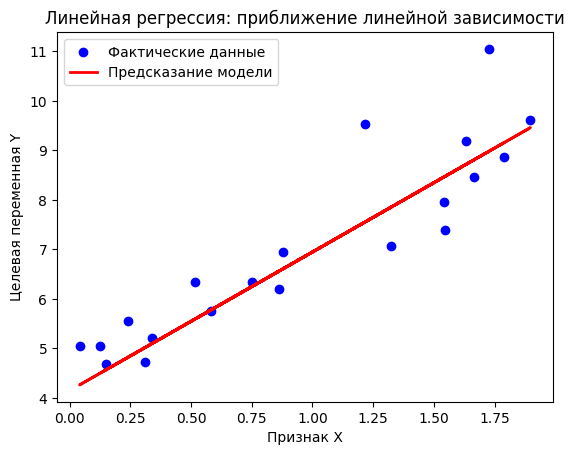

In [172]:
plt.scatter(X_test, y_test, color="blue", label="Фактические данные")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Предсказание модели")
plt.xlabel("Признак X")
plt.ylabel("Целевая переменная Y")
plt.title("Линейная регрессия: приближение линейной зависимости")
plt.legend()
plt.show()

Подготовка данных

In [173]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Date
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3.0,1,5,3,5,5,4,3.0,4.0,4,5,5,25,18.0,neutral or dissatisfied,2022-10-20
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3.0,3,1,3,1,1,1,5.0,3.0,1,4,1,1,6.0,neutral or dissatisfied,2022-10-08
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2.0,2,5,5,5,5,4,3.0,4.0,4,4,5,0,0.0,satisfied,2022-10-11
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5.0,5,2,2,2,2,2,5.0,3.0,1,4,2,11,9.0,neutral or dissatisfied,2022-10-25
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3.0,3,4,5,5,3,3,4.0,4.0,3,3,3,0,0.0,satisfied,2022-10-23


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103910 entries, 0 to 103909
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103910 non-null  int64  
 1   Gender                             103858 non-null  object 
 2   Customer Type                      103910 non-null  object 
 3   Age                                103910 non-null  int64  
 4   Type of Travel                     103910 non-null  object 
 5   Class                              103910 non-null  object 
 6   Flight Distance                    103910 non-null  int64  
 7   Inflight wifi service              103910 non-null  int64  
 8   Departure/Arrival time convenient  103910 non-null  int64  
 9   Ease of Online booking             103792 non-null  float64
 10  Gate location                      103910 non-null  int64  
 11  Food and drink                     1039

In [175]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Ease of Online booking'].fillna(df['Ease of Online booking'].mode()[0], inplace=True)
df['Leg room service'].fillna(df['Leg room service'].mode()[0], inplace=True)
df['Baggage handling'].fillna(df['Baggage handling'].mode()[0], inplace=True)
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mode()[0], inplace=True)

/var/folders/zs/th7t891d5gb13xl22_k4pyt00000gn/T/ipykernel_81785/3993376307.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
/var/folders/zs/th7t891d5gb13xl22_k4pyt00000gn/T/ipykernel_81785/3993376307.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [176]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df = remove_outliers(df, 'Age')

In [177]:
df = df.drop_duplicates()

In [178]:
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 45, 65, 100], labels=['Young', 'Adult', 'Middle_Aged', 'Senior'])
df['Flight_Distance_Type'] = pd.cut(df['Flight Distance'], bins=[0, 300, 600, 900, 1200], labels=['Small', 'Medium', 'Big', 'Enormous'])

In [179]:
df['Date'] = pd.to_datetime(df['Date'])

In [180]:
df['Flight_Weekday'] = df['Date'].dt.weekday
df['Flight_Weekend'] = (df['Flight_Weekday'] >= 5).astype(int)

In [181]:
category_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction', 'Age_Group', 'Flight_Distance_Type']

In [182]:
df_one_hot_enc = pd.get_dummies(df, columns=category_features, drop_first=True)

In [183]:
df_one_hot_enc.head()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Date,Flight_Weekday,Flight_Weekend,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Class_Econom,satisfaction_satisfied,Age_Group_Adult,Age_Group_Middle_Aged,Age_Group_Senior,Flight_Distance_Type_Medium,Flight_Distance_Type_Big,Flight_Distance_Type_Enormous
0,70172,13,460,3,4,3.0,1,5,3,5,5,4,3.0,4.0,4,5,5,25,18.0,2022-10-20,3,0,True,True,False,True,False,False,True,False,False,False,False,False,True,False,False
1,5047,25,235,3,2,3.0,3,1,3,1,1,1,5.0,3.0,1,4,1,1,6.0,2022-10-08,5,1,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False
2,110028,26,1142,2,2,2.0,2,5,5,5,5,4,3.0,4.0,4,4,5,0,0.0,2022-10-11,1,0,False,True,False,False,True,False,False,False,True,True,False,False,False,False,True
3,24026,25,562,2,5,5.0,5,2,2,2,2,2,5.0,3.0,1,4,2,11,9.0,2022-10-25,1,0,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False
4,119299,61,214,3,3,3.0,3,4,5,5,3,3,4.0,4.0,3,3,3,0,0.0,2022-10-23,6,1,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False


In [184]:
print(df.columns)

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'Date', 'Age_Group', 'Flight_Distance_Type',
       'Flight_Weekday', 'Flight_Weekend'],
      dtype='object')


In [185]:
X = df_one_hot_enc.drop(['satisfaction_satisfied', 'id', 'Age', 'Date'], axis=1)
y = df['satisfaction']

In [186]:
X.head()

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Weekday,Flight_Weekend,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Class_Econom,Age_Group_Adult,Age_Group_Middle_Aged,Age_Group_Senior,Flight_Distance_Type_Medium,Flight_Distance_Type_Big,Flight_Distance_Type_Enormous
0,460,3,4,3.0,1,5,3,5,5,4,3.0,4.0,4,5,5,25,18.0,3,0,True,True,False,True,False,False,True,False,False,False,False,True,False,False
1,235,3,2,3.0,3,1,3,1,1,1,5.0,3.0,1,4,1,1,6.0,5,1,True,False,True,False,True,False,False,False,False,False,False,False,False,False
2,1142,2,2,2.0,2,5,5,5,5,4,3.0,4.0,4,4,5,0,0.0,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False,True
3,562,2,5,5.0,5,2,2,2,2,2,5.0,3.0,1,4,2,11,9.0,1,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False
4,214,3,3,3.0,3,4,5,5,3,3,4.0,4.0,3,3,3,0,0.0,6,1,True,True,False,False,True,False,False,False,False,True,False,False,False,False


In [187]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [195]:
def predict_results(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, pos_label='satisfied')
    recall = recall_score(y_valid, y_pred, pos_label='satisfied')
    f1 = f1_score(y_valid, y_pred, pos_label='satisfied')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid)
    plt.show()

In [196]:
smote = SMOTE(
    sampling_strategy='auto',
    random_state=42
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [197]:
print(y_train.value_counts())
print(y_train_resampled.value_counts())

satisfaction
neutral or dissatisfied    47100
satisfied                  36017
Name: count, dtype: int64
satisfaction
neutral or dissatisfied    47100
satisfied                  47100
Name: count, dtype: int64


Логистическая регрессия
Для лог регрессии - перебрать все виды penalty (т.е. регуляризации), solver (оптимизаторы)

In [198]:
from sklearn.linear_model import LogisticRegression

In [209]:
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

In [212]:
param_grid_lr = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga']
    },
    {
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs', 'saga']
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga']
    }
]

In [230]:
from sklearn.model_selection import GridSearchCV

grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X, y)

print(grid_lr.best_params_)
print(grid_lr.best_score_)

/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead

{'penalty': 'l1', 'solver': 'liblinear'}
nan


In [242]:
best_lr_model = grid_lr.best_estimator_
print(best_lr_model)

LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


In [251]:
lr_model = LogisticRegression(
    penalty="l1",
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)

In [252]:
print(y_valid.value_counts())

satisfaction
neutral or dissatisfied    11775
satisfied                   9005
Name: count, dtype: int64


Без сэмплирования

/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Accuracy: 0.8807, Precision: 0.8760, Recall: 0.8442, F1-score: 0.8598


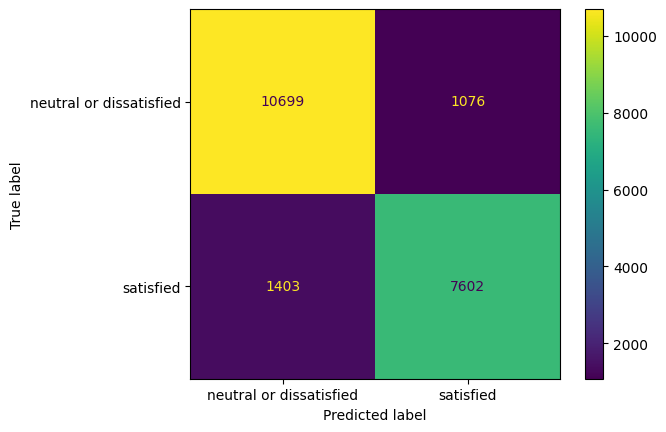

In [253]:
predict_results(lr_model, X_train, X_valid, y_train, y_valid)

С сэмплированием

/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Accuracy: 0.8744, Precision: 0.8561, Recall: 0.8537, F1-score: 0.8549


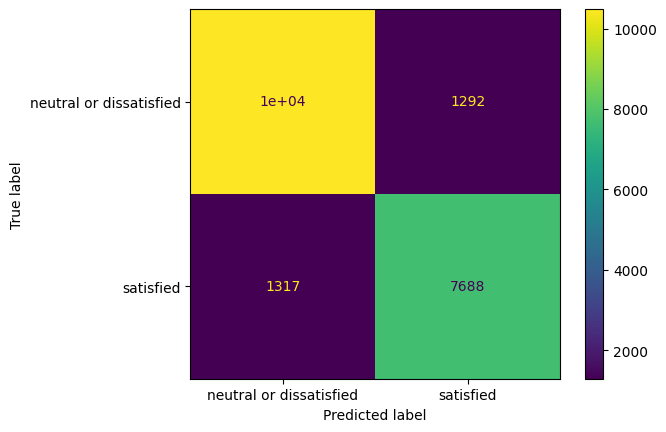

In [254]:
predict_results(lr_model, X_train_resampled, X_valid, y_train_resampled, y_valid)

Разница мала, но сэмплирование имело скорее отрицательный эффект, чем положительный

KNN
Для knn - перебрать разное количество ближайших соседей (например, от 3 до 10), weights (типы определения весов)

In [231]:
from sklearn.neighbors import KNeighborsClassifier

In [232]:
param_grid_knn = {
    'n_neighbors': list(range(3, 11)),
    'weights': ['uniform', 'distance']
}

In [233]:
knn_model = KNeighborsClassifier()

In [236]:
grid_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid_knn,
    scoring='f1',
    cv=5
)

grid_knn.fit(X, y)

print(grid_knn.best_params_)
print(grid_knn.best_score_)

/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", l

{'n_neighbors': 3, 'weights': 'uniform'}
nan


/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", l

In [243]:
best_knn_model = grid_knn.best_estimator_
print(best_knn_model)

KNeighborsClassifier(n_neighbors=3)


In [255]:
knn_model = KNeighborsClassifier(
    n_neighbors=3,
    weights="uniform"
)

Без сэмплирования

Accuracy: 0.7719, Precision: 0.7565, Recall: 0.6985, F1-score: 0.7263


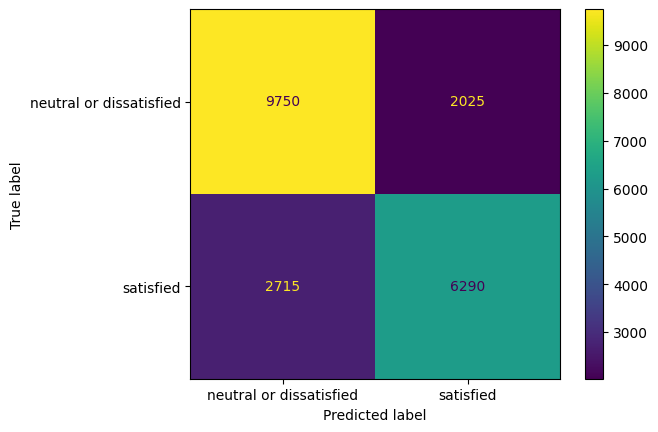

In [256]:
predict_results(knn_model, X_train, X_valid, y_train, y_valid)

С сэмплированием

Accuracy: 0.7572, Precision: 0.7089, Recall: 0.7461, F1-score: 0.7270


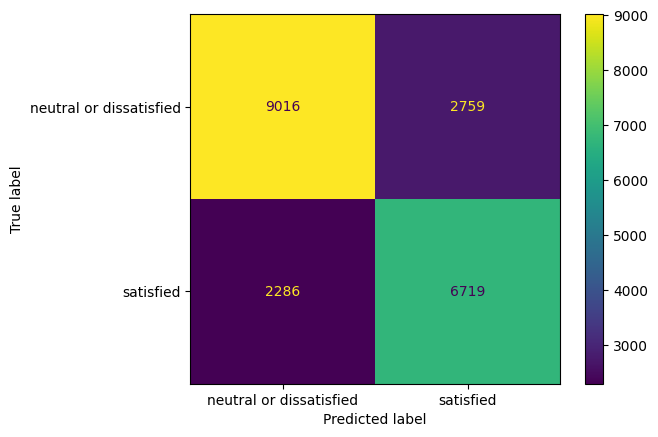

In [257]:
predict_results(knn_model, X_train_resampled, X_valid, y_train_resampled, y_valid)

Результат противоречивый. F1 выше, но остальные характеристики снизились

Дерево решений
Для дерева решений - перебрать разные значения для глубины дерева, минимального количества объектов в листе, критериев разбиения

In [237]:
from sklearn.tree import DecisionTreeClassifier

In [238]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

In [239]:
dt_model = DecisionTreeClassifier(random_state=42)

In [245]:
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    scoring='f1',
    cv=5
)

grid_dt.fit(X, y)

print(grid_dt.best_params_)
print(grid_dt.best_score_)

/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariyamatveeva/Desktop/Новая папка/dz2/smote_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", l

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}
nan


In [247]:
best_dt_model = grid_dt.best_estimator_
print(best_dt_model)

DecisionTreeClassifier(random_state=42)


In [258]:
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    min_samples_leaf=1,
)

Без сэмплирования

Accuracy: 0.9426, Precision: 0.9307, Recall: 0.9373, F1-score: 0.9340


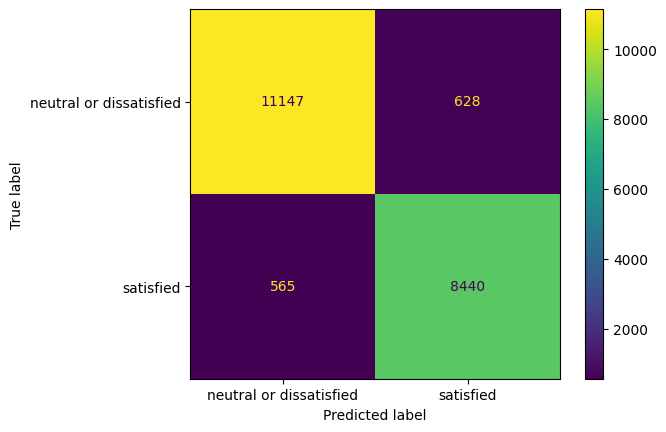

In [259]:
predict_results(dt_model, X_train, X_valid, y_train, y_valid)

С сэмплированием

Accuracy: 0.9413, Precision: 0.9270, Recall: 0.9386, F1-score: 0.9327


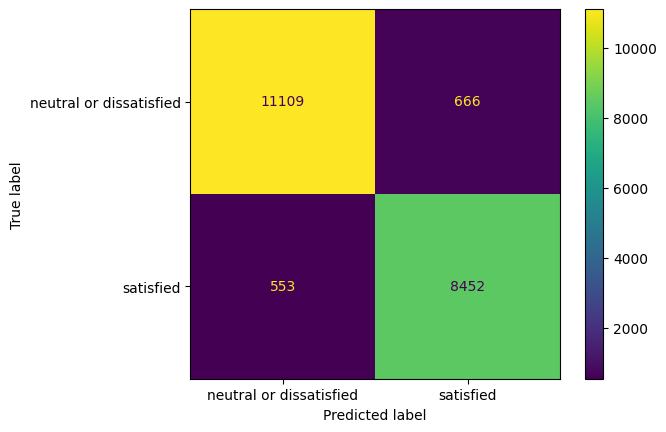

In [260]:
predict_results(dt_model, X_train_resampled, X_valid, y_train_resampled, y_valid)

Разница очень мала, но без сэмплироания несколько лучше

In [261]:
feature_importances = best_dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Признак": X.columns,
    "Важность": feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by="Важность", ascending=False)

feature_importance_df

,Признак,Важность
6,Online boarding,0.362791
1,Inflight wifi service,0.178955
22,Type of Travel_Personal Travel,0.146392
8,Inflight entertainment,0.048895
21,Customer Type_disloyal Customer,0.036235
12,Checkin service,0.027525
0,Flight Distance,0.025402
4,Gate location,0.022160
23,Class_Business,0.020414
7,Seat comfort,0.015919


В данном случае качество модели дерева решений заметно лучше логистической регрессии и knn (разница между логистической регрессией и knn крайне мала). Предпочтительнее выбрать дерево решений без сэмплироавния Accuracy: 0.9426, Precision: 0.9307, Recall: 0.9373, F1-score: 0.9340